In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [101]:
df = pd.read_excel('C:\\Users\\gizemaysan\\Desktop\\tahminleme\\satis.xlsx')

In [102]:
data_gercek = pd.read_excel('C:\\Users\\gizemaysan\\Desktop\\tahminleme\\gerçek.xlsx')

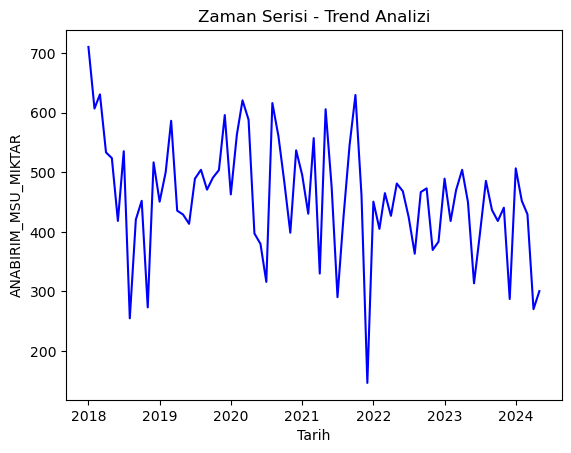

In [103]:
df['AY'] = pd.to_datetime(df['AY'])  # Zaman serisinin tarih kolonu
plt.plot(df["AY"], df['ANABIRIM_MSU_MIKTAR'], label='Veri', color='blue')
plt.xlabel('Tarih')
plt.ylabel('ANABIRIM_MSU_MIKTAR')
plt.title('Zaman Serisi - Trend Analizi')
plt.show()


In [104]:
df["AY"] = pd.to_datetime(df["AY"])
df.set_index("AY", inplace=True)

In [105]:
df = df.asfreq('MS')

In [106]:
data_gercek['AY'] = pd.to_datetime(data_gercek['AY'], errors='coerce')
data_gercek.set_index('AY', inplace=True)

In [107]:
from scipy import stats

# Z-Score hesaplama
z_scores = np.abs(stats.zscore(df['ANABIRIM_MSU_MIKTAR']))
outliers = np.where(z_scores > 3)  # 3'ten büyük olan değerler aykırıdır

# Aykırı değerleri kontrol et
print(f"Aykırı Değerler: {df.iloc[outliers]}")


Aykırı Değerler:             ANABIRIM_MSU_MIKTAR
AY                             
2021-12-01           146.106688


In [108]:
Q1 = df['ANABIRIM_MSU_MIKTAR'].quantile(0.25)
Q3 = df['ANABIRIM_MSU_MIKTAR'].quantile(0.75)
IQR = Q3 - Q1

# Aykırı değerlerin sınırları
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Aykırı değerleri bulma
outliers = df[(df['ANABIRIM_MSU_MIKTAR'] < lower_bound) | (df['ANABIRIM_MSU_MIKTAR'] > upper_bound)]
print(f"Aykırı Değerler: {outliers}")


Aykırı Değerler:             ANABIRIM_MSU_MIKTAR
AY                             
2018-01-01           710.563167
2018-08-01           254.624061
2018-11-01           272.988609
2021-12-01           146.106688
2024-04-01           270.048536


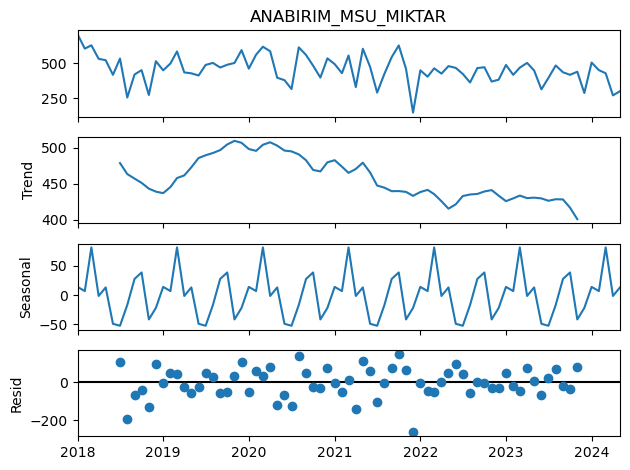

In [109]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['ANABIRIM_MSU_MIKTAR'], model='additive', period=12)
result.plot()
plt.show()

In [110]:
# IQR ile aykırı değerleri bulma
Q1 = df['ANABIRIM_MSU_MIKTAR'].quantile(0.25)
Q3 = df['ANABIRIM_MSU_MIKTAR'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Aykırı değerlerin medyan ile değiştirilmesi
df['ANABIRIM_MSU_MIKTAR'] = np.where(df['ANABIRIM_MSU_MIKTAR'] < lower_bound, df['ANABIRIM_MSU_MIKTAR'].median(), df['ANABIRIM_MSU_MIKTAR'])
df['ANABIRIM_MSU_MIKTAR'] = np.where(df['ANABIRIM_MSU_MIKTAR'] > upper_bound, df['ANABIRIM_MSU_MIKTAR'].median(), df['ANABIRIM_MSU_MIKTAR'])


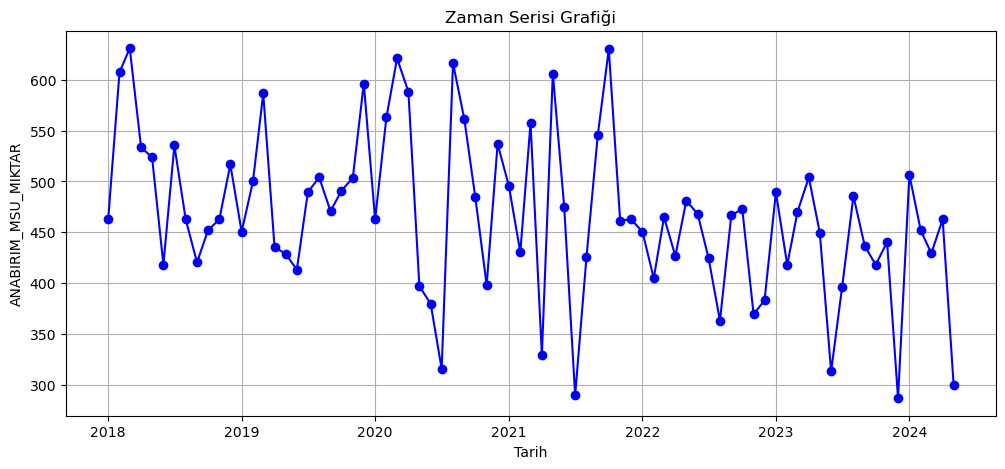

In [111]:
plt.figure(figsize=(12,5))
plt.plot(df, marker="o", linestyle="-", color="b")
plt.title("Zaman Serisi Grafiği")
plt.xlabel("Tarih")
plt.ylabel("ANABIRIM_MSU_MIKTAR")
plt.grid()
plt.show()

In [112]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["ANABIRIM_MSU_MIKTAR"])
print("ADF Test İstatistiği:", result[0])
print("p-değeri:", result[1])
print("Kritik Değerler:", result[4])

ADF Test İstatistiği: -7.0863186453651315
p-değeri: 4.5287814302602983e-10
Kritik Değerler: {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}


In [113]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [148]:
seasonal_period = 12 # Yıllık mevsimsellik (12 ay)
model = ExponentialSmoothing(df["ANABIRIM_MSU_MIKTAR"], 
                             trend="mul",         # Çarpanlı trend bileşeni ekliyoruz
                             seasonal="add",      # Toplam mevsimsellik ekliyoruz
                             seasonal_periods=seasonal_period, 
                             initialization_method="estimated").fit()  # Başlangıç tahminini otomatik olarak yap

# 9 adım (ay) için tahmin yap
forecast = model.forecast(steps=9)

C:\Users\gizemaysan\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


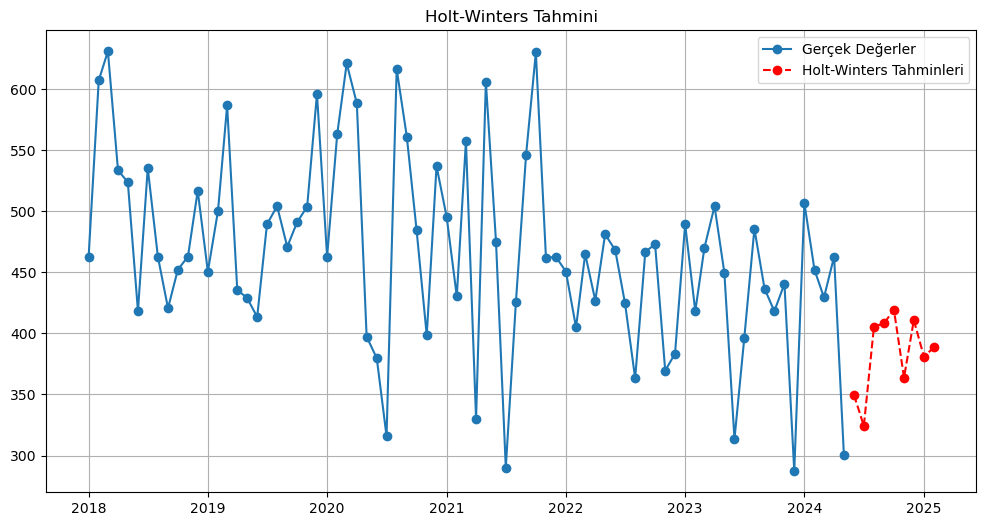

In [149]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["ANABIRIM_MSU_MIKTAR"], label="Gerçek Değerler", marker="o")
plt.plot(forecast.index, forecast, label="Holt-Winters Tahminleri", marker="o", linestyle="dashed", color="red")
plt.legend()
plt.title("Holt-Winters Tahmini")
plt.grid()
plt.show()

In [150]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(data_gercek["ANABIRIM_MSU_MIKTAR"], forecast))
print(f"RMSE: {rmse:.4f}")

RMSE: 63.4058


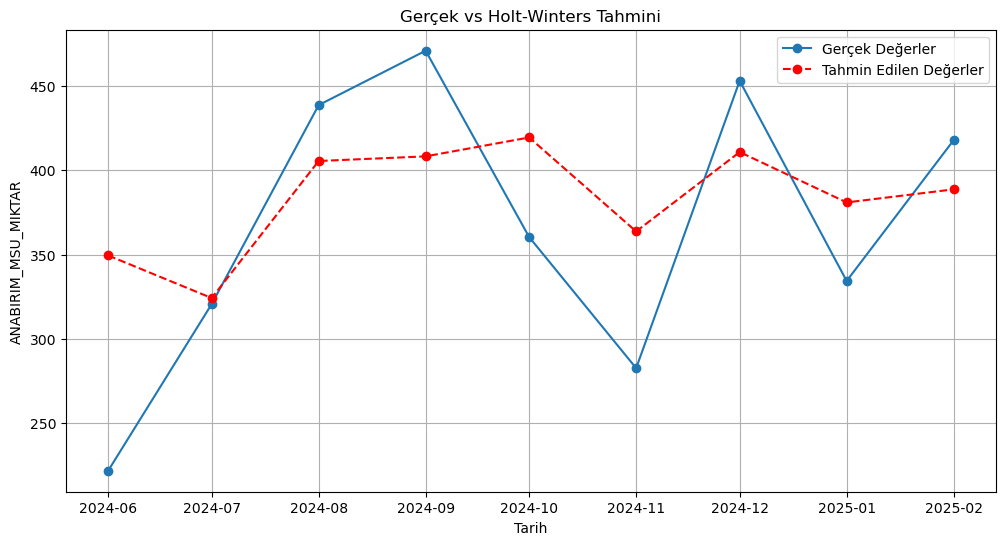

In [151]:
plt.figure(figsize=(12,6))
plt.plot(data_gercek.index, data_gercek["ANABIRIM_MSU_MIKTAR"], label="Gerçek Değerler", marker="o", linestyle="-")
plt.plot(forecast.index, forecast, label="Tahmin Edilen Değerler", marker="o", linestyle="dashed", color="red")
plt.legend()
plt.title("Gerçek vs Holt-Winters Tahmini")
plt.xlabel("Tarih")
plt.ylabel("ANABIRIM_MSU_MIKTAR")
plt.grid()
plt.show()

In [122]:
forecast

2024-06-01    426.191632
2024-07-01    355.141475
2024-08-01    408.286917
2024-09-01    484.138025
2024-10-01    471.823925
2024-11-01    356.503177
2024-12-01    370.981420
2025-01-01    323.912516
2025-02-01    425.555707
Freq: MS, dtype: float64